# **Machine Learning Group Project: Team 7**
## Project introduction

| Student Name | Student Number | Class Group |
| --- | --- | --- |
| **Alessandro Maugeri** | 53067 | TA |
| **Frank Andreas Bauer** | 53121 | TA |
|  **Johannes Rahn** | 53958 | TB |
| **Nicole Zoppi** | 53854 | TB |
| **Yannick von der Heyden** | 53629 | TA |



- **Course & Course Code:** Machine Learning (2487)
- **Instructors:** Qiwei Han & Alessandro Gambetti
- **Academic Year:** 2022/2023


This project was developed by Alessandro Alfio Maugeri, Frank Andreas Bauer, Johannes Rahn, Nicole Zoppi, and Yannick von der Heyden as part of Nova SBE's Machine Learning course taught during Semester 2 of the 2022/2023 academic year by Qiwei Han and Alessandro Gambetti. The purpose of the group work is to develop an end-to-end Machine Learning project with data of our choice, clearly highlighting the business use for our model.

The project exploits data from two distinct Kaggle pages ("Game Recommendations on Steam" and "Steam Store Games (Clean dataset)") which contain data on content published to the **Steam libary** (e.g. games and DLCs) and user-generated content associated with it (e.g. whether a review is positive or not, what general consensus is, how many people found the review useful, etc.). The final work merges data from 4 distinct CSV files and 1 JSON, all of which can be found in the data folder and all of whose contents are covered in detail in the current Notebook.

The objective is to develop a Machine Learning pipeline from beginning to end whose output has a clear, pertinent, and useful business use. In this project, we explore multiple models in order to identify the one which is best-suited for **predicting whether a given Steam user will enjoy a game or not**. This should allow Steam to optimize its service by tailoring it to individual clients and fine-tuning their recommender systems.

To guarantee a better computing perfomance, we split the project steps into 3 distinct Notebooks, meant to be run in succession. 

1. **a_csv_creation**. The current notebook presents the outline of the projects and reads data from the various datasets used, merging them into a final one (final_df) used for the following Notebooks.
2. **b_recommender_system**. The purpose of this notebook is to extract content-based similarities across different products on the basis of the plethora of of textual data contained in descriptive columns such as tags, genres, description, or steamspy_tags. These findings can later be utilized when building other models.
3. **c_data_exploration** TO ADD

---- 
Make sure to **only run this notebook once the previous notebooks [a_csv_creation.ipynb](a_csv_creation.ipynb) and [b_recommender_system.ipynb](b_recommender_system.ipynb) have been run at least once.** 

If those notebooks have both been run at least once, the kernel may be restarted before running this in order to obtain better performance and vaster machine memory.

## Importing Packages 

In [1]:
import ast
import csv
import datetime
import warnings
import scipy
import pandas as pd
import numpy as np
from datetime import datetime
from kneed import KneeLocator
from category_encoders import TargetEncoder

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# From sklearn
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler


# From imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

# From scipy
from scipy.stats import chi2_contingency, pointbiserialr

## Reading DataFrame

In [2]:
# Optimizing datatypes for efficient DF storage
data_types = {
    'review_id': 'int32',
    'y': 'bool',
    'funny': 'int16',
    'helpful': 'int16',
    'app_id': 'int32',
    'title': 'string',
    'rating': 'category',
    'positive_ratio': 'int16',
    'user_reviews': 'int32',
    'win': 'bool',
    'mac': 'bool',
    'linux': 'bool',
    'price_final': 'float32',
    'price_original': 'float32',
    'discount': 'float32',
    'description': 'string',
    'tags': 'string',
    'english': 'int8',
    'developer': 'category',
    'publisher': 'category',
    'required_age': 'int8',
    'genres': 'string',
    'steamspy_tags': 'string',
    'achievements': 'int16',
    'average_playtime': 'int32',
    'median_playtime': 'int32',
    'owners': 'category',
    'steam_deck': 'bool',
    'user_id': 'int32',
    'products': 'int16',
    'reviews': 'int16',
    'hours': 'float32',
    'categories': 'string'
}

In [3]:
# Import the final DataFrame
final_df = pd.read_csv("data/final_df.csv",
                       dtype=data_types, parse_dates=['date', 'date_release'])

# Import the Textual Data
textual_df = pd.read_csv("data/textual_data.csv", index_col = "app_id")

In [4]:
# Rearrange Columns
final_df = final_df.reindex(columns = ["review_id", "y", "date", "funny", "helpful",
                                       "app_id", "title", "date_release", "rating", 
                                       "positive_ratio", "user_reviews", "win", "mac", "linux", 
                                       "price_final", "price_original", "discount", "description",
                                       "tags", 'english', 'developer', 'publisher', 'required_age', 
                                       'genres', 'steamspy_tags','achievements', 'average_playtime', 
                                       'median_playtime', "owners", "steam_deck",
                                       "user_id", "products", "reviews", "hours"])

# Sort by Review ID
final_df.sort_values(by=["review_id"], inplace = True)

In [5]:
final_df.shape

(6564923, 34)

## Stratified Resampling

The code below performs stratified sampling on the dataset. We do not have the computing power to run all our models on the complete set. Consequently, we provide the possibility of sampling the data down to 100,000 (minimum sample), 500,000 (medium sample), or 1,000,000 (medium-high) sample, should the computing power be sufficient. The data is stratified according to the target variable so as to prevent the further loss of negative feedback, which is already a strong minority in the set, as will be shown later in the notebook.

Alternatively, by skipping the lines of code below one can use the complete dataset with 6,564,923 observations. This naturally requires the appropriate computing power. *Due to our limited computing power, we will be running the entire notebook on 500,000 observations*.

In [6]:
n_total_samples = 100000
#n_total_samples = 500000
#n_total_samples = 1000000

In [7]:
# Find Negative-Positive Ratio
neg_pos_ratio = final_df['y'].value_counts()[0] / final_df['y'].value_counts()[1]

# Determine Number of False and Number of True Samples
n_false_samples = int(n_total_samples * neg_pos_ratio)
n_true_samples = n_total_samples - n_false_samples

# Sample On this Basis 
false_samples = final_df[final_df['y'] == False].sample(n_false_samples, random_state=70)
true_samples = final_df[final_df['y'] == True].sample(n_true_samples, random_state=70)

final_df = pd.concat([false_samples, true_samples])

# shuffle the data
final_df = final_df.sample(frac=1, random_state=70)

*EXPLANATION FOR HANDLING OF REVIEW-RELATED DATA*

We drop all the data inherently describing reviews because they cannot be used as inputs for the models (it is data collected after the acquisition of a game)

In [8]:
# Drop Tags, SteamSpy Tags, Description, Genres (as Single-Column List)
final_df.drop(['review_id', 'funny', 'helpful'], 
              axis = 1, inplace = True)

## Data Exploration

### General Analysis

**VERY HIGH-LEVEL DATA EXPLORATION FIRST**

E.G. AMOUNT OF DIFFERENT FEATURES, COLUMN NAMES

IMPORTANT TO SAY: WE DEFINE IN DETAIL WHAT EACH COLUMN MEANS IN THE FINAL_DF_PREP NOTEBOOK. SO IF SOME LABELS ARE UNCLEAR, REFER TO THAT.

In [9]:
column_list = final_df.columns.tolist()
print(column_list)

['y', 'date', 'app_id', 'title', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'win', 'mac', 'linux', 'price_final', 'price_original', 'discount', 'description', 'tags', 'english', 'developer', 'publisher', 'required_age', 'genres', 'steamspy_tags', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'steam_deck', 'user_id', 'products', 'reviews', 'hours']


In [10]:
print(len(column_list))

31


In [11]:
final_df.dtypes

y                             bool
date                datetime64[ns]
app_id                       int32
title                       string
date_release        datetime64[ns]
rating                    category
positive_ratio               int16
user_reviews                 int32
win                           bool
mac                           bool
linux                         bool
price_final                float32
price_original             float32
discount                   float32
description                 string
tags                        string
english                       int8
developer                 category
publisher                 category
required_age                  int8
genres                      string
steamspy_tags               string
achievements                 int16
average_playtime             int32
median_playtime              int32
owners                    category
steam_deck                    bool
user_id                      int32
products            

### Target Variable Exploration

First we explore the distribution of our target variable _y_, which is a column of booleans which signal whether a given user would recommend a given game or not.

In creating a countplot, we find that the dataset is rather unbalanced. Only 14.12% of observations is negative, while the remaining 85.88% is positive. This will certainly be kept in consideration when training our model, as the unbalance must be offset. With a quick calculation, we find that the ratio of positives to negatives is 6.08 approximately.

<Figure size 720x360 with 0 Axes>

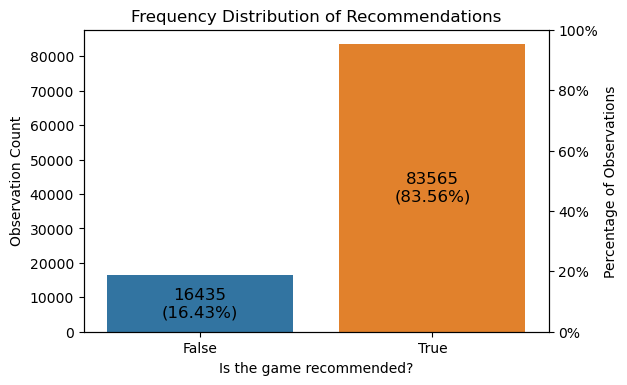

In [12]:
# Plotting the frequency distribution of number of recommendations
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)

ax = sns.countplot(x='y', data=final_df)

plt.title('Frequency Distribution of Recommendations')
plt.xlabel('Is the game recommended?')
plt.ylabel('Observation Count')

# Calculate percentage of each category
percentages = final_df['y'].value_counts(normalize=True) * 100

# Annotate the bars with counts and percentages
for p in ax.patches:
    count = int(p.get_height())
    percentage = percentages.sort_values()[int(p.get_x() + p.get_x())]
    ax.annotate(f'{count}\n({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')

# Add percentage axis
ax2 = ax.twinx()
ax2.set_ylim(0, 100)
ax2.set_ylabel('Percentage of Observations')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [13]:
print("The \033[1mratio of positive to negative recommendations\033[0m is", 
     final_df['y'].value_counts()[0] / final_df['y'].value_counts()[1])

The ratio of positive to negative recommendations is 0.1966732483695327


### Steam Rating Exploration

Reamining within the realm of ratings, we explore the distribution of the Steam rating system through a frequency table. Very interestingly, we observe that many of the rating categories are not in fact present in our data. It would seem that there are no games with overall negative reviews, while most games either have a _Very Positive_ or _Overwhelmingly Positive_ rating (appr. 86.24%). All in all, this is in line with the previous observation concerning the unbalanced dataset. 

Another noteworthy aspect of the dataset is that there are no _Positive_ reviews. The remaining 13.76% is split between _Mostly Positive_ and _Mixed_, with the former counting more observation than the latter. It is worth remembering that the Steam rating system assigns the _Positive_ rating to games that seem to have good ratings, but a review count which is not high enough to really "consacrate" its status as a very positively (or overwhlemingly positively) rated game. This perhaps informs us on the type of game which tends to be included in these datasets, focusing on larger more "mainstream" products rather than smaller lesser-known ones.

In [14]:
# Create a frequency table
rating_counts = pd.DataFrame(final_df['rating'].value_counts())

# Rename the columns
rating_counts.columns = ['Observation Count']

# Sort the rows based on the order of rating categories
rating_order = ["Overwhelmingly Positive", "Very Positive", "Positive", 
                "Mostly Positive", "Mixed", "Mostly Negative", 
                "Negative", "Very Negative", "Overwhelmingly Negative"]

rating_counts = rating_counts.reindex(rating_order)

# Fill NaN with 0
rating_counts.fillna(0, inplace = True)

# Add a column for percentage of observations
rating_counts['Percentage of Observations'] = rating_counts['Observation Count'] / len(final_df) * 100

# Format the percentage column
rating_counts['Percentage of Observations'] = rating_counts['Percentage of Observations'].map('{:.2f}%'.format)

# Turn to Integer
rating_counts["Observation Count"] = [int(i) for i in rating_counts["Observation Count"]]

display(rating_counts)

,Observation Count,Percentage of Observations
Overwhelmingly Positive,23255,23.25%
Very Positive,62738,62.74%
Positive,0,0.00%
Mostly Positive,11689,11.69%
Mixed,2318,2.32%
Mostly Negative,0,0.00%
Negative,0,0.00%
Very Negative,0,0.00%
Overwhelmingly Negative,0,0.00%


### Owners Exploration

We plot the ownership data, which is currently subdivided in categorical strings which simply describe the range of users which any given game has. For the purposes of our model, this will clearly have to be transformed through some form of ordinal encoding. We look at the distribution of these games to gain actionable insights on how data is distributed across these categories, and whether some of these categories can be "condensed" together. This may simplify our eventual model and has the added benefit of ironing out categories which may contain a number of observations far too small compared to other categories. The implication here being that if the data were too unbalanced, it would become more difficult for an eventual regression to truly establish clear statistically significant links.


CHOOSE ONE OF THE PLOTS BELOW AND EXPAND ON IT.

<Figure size 720x360 with 0 Axes>

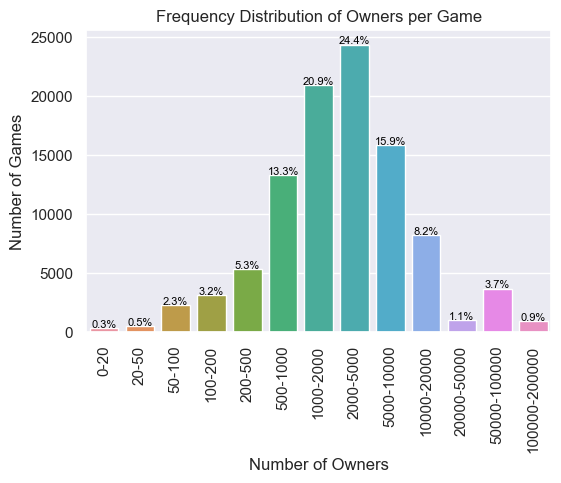

In [15]:
# Create Order
order_list = ["0-20", "20-50", "50-100", "100-200", "200-500",
              "500-1000", "1000-2000", "2000-5000", "5000-10000",
              "10000-20000", "20000-50000", "50000-100000", 
              "100000-200000"]

# Plotting the frequency distribution of owners
sns.set_theme()
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.xticks(rotation=90)

ax = sns.countplot(x='owners', data=final_df,
                  order = order_list)

# Add percentages to plot
total = len(final_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 30
    ax.annotate(percentage, (x, y), ha='center', fontsize=8, color='black')

plt.title("Frequency Distribution of Owners per Game")
plt.xlabel('Number of Owners')
plt.ylabel('Number of Games')
plt.show()

### Double check text
The feature owner describes the Number of Users that Own the Game.



### Discount Rates

Given that discounts are part of the sales process, we attempt to establish whether the _discount_ column contains a satisfactory range of values which may allow us to appropriately enhance the model (or perhaps construct some form of additional model to predict offered discount). 

The results here are rather disappointing due to the limited range of unique values which this column takes (11), which almost makes it more of a discrete variable than continuous one. Furthermore, only discounts above 50% were retained in this dataset and they are a very large minority compared to games which were purchased at full price.

It would seem that the rich range of possible discounts which were found to exist in [a_csv_creation.ipynb](a_csv_creation.ipynb) were lost in the merging process, particularly when merging the recommendations dataset. This is problematic given that the dataframe is the only truly indispensible one for our model, therefore we cannot run any join that would force games into the dataframe which it does not contain any data for. In that case, we would be foregoing the game-user pairing which is intrinsicially necessary to building our analysis. We do not believe building a model based on the games.csv alone would be useful, as discounts on these platforms are not solely based on game characteristics, but also whether a user is deemed to a good fit for a certain special offer. 

Given these considerations, we will later build a rule-based discount determiner as opposed to a fully automated machine-learning algorithm.

In [16]:
print("Number of Unique Values in discount column:", len(final_df["discount"].value_counts()))

Number of Unique Values in discount column: 11


In [17]:
discount_count = final_df["discount"].value_counts()
discount_perc = final_df["discount"].value_counts(normalize=True) * 100
discount_df = pd.DataFrame({'Discount Count': discount_count, 'Discount Percentage': discount_perc})
discount_df.index = [f'{round(i, 2)}%' for i in discount_df.index]
discount_df.sort_index(ascending=True, inplace=True)
discount_df

,Discount Count,Discount Percentage
0.0%,94171,94.171
50.0%,435,0.435
60.0%,1100,1.100
65.0%,208,0.208
66.0%,304,0.304
67.0%,112,0.112
75.0%,1618,1.618
80.0%,538,0.538
84.0%,107,0.107
85.0%,134,0.134


### **Final Prices**

This boxplot provides us with a visual summary of the distribution of the final prices in the dataset. It shows the median, lower quartile, upper quartile, and any potential outliers in the data. This helps us to understand the range and spread of the final prices, which can provide insights into pricing strategies or market conditions.

It also helps us to identify potential outliers in the data. Those outliers may indicate errors, unusual pricing patterns, or unique market conditions. Identifying these outliers can help you better understand the data and decide how to handle them in further analysis.

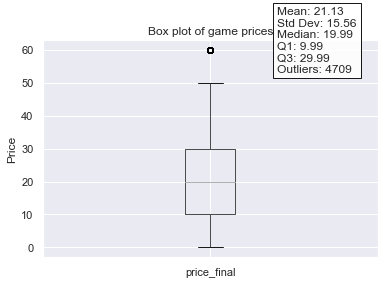

In [18]:
# boxplot of final price

ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


The mean (average) of the data is 20.82, which means that the typical value in the dataset is around 21.32. The median (middle value) is 19.99, which suggests that half of the data points are below 19.99 and half are above it. Since the mean and median are close to each other, this implies that the data distribution might be roughly symmetrical.

The standard deviation (Std. Dev.) of 16.95 indicates that the data points are spread out over a range of approximately 16.95 units from the mean. A larger standard deviation suggests greater variability in the dataset.

The first quartile (Q1) is 7.99, which means that 25% of the data points are below 7.99. The third quartile (Q3) is 29.99, indicating that 75% of the data points are below 29.99.

There are no outliers in this dataset, which means that all data points fall within a reasonable range and there are no extreme values that could potentially skew the interpretation.

### Game developers and publishers

In this section we explore the top 10 developers and publishers (number of games published and rating). It is important to note that developers can match or be different from publishers.

#### Top 10 ranking of number of unique games released by developers and publisher**

In [19]:
# Count the number of unique games released by each developer
developer_counts = final_df.groupby('developer')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_developers = developer_counts.sort_values(ascending=False).head(10)

# Count the number of unique games released by each developer
publisher_counts = final_df.groupby('publisher')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_publishers = publisher_counts.sort_values(ascending=False).head(10)

# Combine top 10 developers and top 10 publishers DataFrames
top_10_developers_df = top_10_developers.to_frame().reset_index().rename(columns={'title': 'unique_games'})
top_10_publishers_df = top_10_publishers.to_frame().reset_index().rename(columns={'title': 'unique_games'})
combined_df = pd.concat([top_10_developers_df, top_10_publishers_df], axis=1, keys=['Developers', 'Publishers'])

# Print the top 10 developers and top 10 publishers side by side
combined_df

Developers                                 Publishers  \
                    developer unique_games                     publisher   
0                       Valve            6                       Ubisoft   
1       Bethesda Game Studios            6            Bethesda Softworks   
2  KOEI TECMO GAMES CO., LTD.            4           Paradox Interactive   
3    Spike Chunsoft Co., Ltd.            4                          SEGA   
4            CAPCOM Co., Ltd.            4                         Valve   
5  Paradox Development Studio            4      Spike Chunsoft Co., Ltd.   
6                 Square Enix            3    BANDAI NAMCO Entertainment   
7      Obsidian Entertainment            3                    Activision   
8                    Treyarch            3                   Square Enix   
9                      Capcom            3  2K;Aspyr (Mac);Aspyr (Linux)   

                
  unique_games  
0           10  
1           10  
2            8  
3            8  
4            8  
5            8  
6            6  
7            5  
8            5  
9            4

In [20]:
unique_games = final_df['title'].nunique()
print(f"Number of unique games: {unique_games}")

Number of unique games: 299


In [21]:
unique_developers = final_df['developer'].nunique()
print(f"Number of unique developers: {unique_developers}")


Number of unique developers: 251


In [22]:
unique_publishers = final_df['publisher'].nunique()
print(f"Number of unique publishers: {unique_publishers}")


Number of unique publishers: 197


#### Top 10 ranking of developers with best positive rating

In [23]:
# Calculate the average positive rating for each developer
average_positive_ratings = final_df.groupby('developer')['positive_ratio'].mean()

# Sort the developers by the average positive rating in descending order and get the top 10
top_10_developers_positive_ratings = average_positive_ratings.sort_values(ascending=False).head(10)

# Print the top 10 developers with the best average positive ratings
top_10_developers_positive_ratings


developer
Kristjan Skutta          98.0
Ludeon Studios           98.0
ConcernedApe             98.0
Bevan McKechnie          97.0
Matt Makes Games Inc.    97.0
Monomi Park              97.0
Lucas Pope               97.0
Nicalis, Inc.            97.0
Ninja Kiwi               97.0
Re-Logic                 97.0
Name: positive_ratio, dtype: float64

The results of the top 10 developers with the most unique games don't match the list of the top 10 developers based on best positive ratings. Therefore, we can conclude that a developer who has developed more games does not necisarrily develop better rated games.

### **Relationship between Products Owned and Number of Reviews**

Looking at the relationship between products owned and the number of reviews can give insight into user engagement with a product.

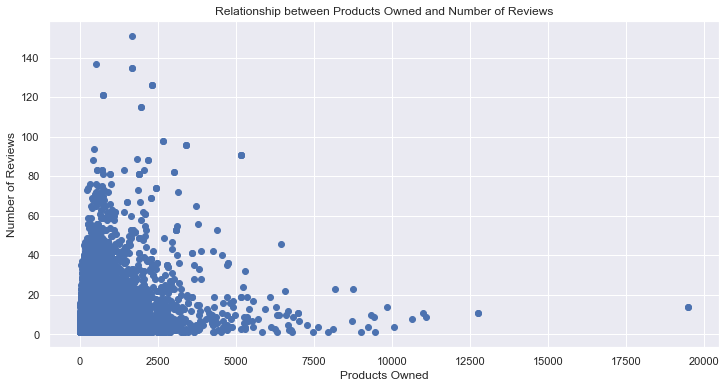

Correlation coefficient between Products Owned and Number of Reviews: 0.32


In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(final_df['products'], final_df['reviews'])
plt.xlabel('Products Owned')
plt.ylabel('Number of Reviews')
plt.title('Relationship between Products Owned and Number of Reviews')
plt.show()

correlation = final_df['products'].corr(final_df['reviews'])
print(f"Correlation coefficient between Products Owned and Number of Reviews: {correlation:.2f}")

The correlation coefficient of 0.32 indicates a weak positive relationship between the number of products owned and the number of reviews written. This means that, in general, as the number of products owned increases, there is a slight tendency for the number of reviews written to increase as well.

Some of the reasons for this weak positive correlation could be:

- Time constraints: Users who own a large number of games might not have enough time to play all of them extensively, and thus may not feel confident in writing a review for each game.
- Review motivation: Different users might have varying motivations for writing reviews. Some might only write reviews for games they are passionate about, while others might review games they had a negative experience with. The number of products owned may not directly influence these motivations.
- Game quality and user preferences: Not all games are equally engaging, and users might only write reviews for games that align with their preferences or that they find exceptionally good or bad.
- Review-writing habits: Some users might be more inclined to write reviews than others, regardless of the number of games they own. For example, a user who is an active participant in the Steam community might write more reviews than someone who mainly uses the platform to play games.

### **Compatibility of Windows, Mac and Linux**

Analyzing the compatibility between different operating systems helps us to understand the market distribution of each platform. Each operating system has a different market share, and understanding the distribution can inform developers about potential target audiences and which platforms are more popular among users. Different user groups may have preferences for specific platforms due to factors such as available software, hardware compatibility, or personal taste. 

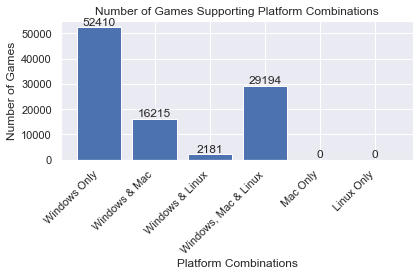

In [25]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The plot shows that Windows definitly dominates, when it comes to the number of games it supports. Most developers only develop for windows. However, there are still many games which run on windows, mac and linux. These results tell us that we should consider a users operating system, when recommending a game based on a user_id.

### **Trends in game releases, user reviews, and ratings over time**

Analyzing the follwing trends helps us to identify patterns in the gaming industry, such as seasonal variations in game releases and user reviews. Understanding these patterns can help stakeholders like game developers and publishers to make more informed decisions and tailor their strategies accordingly. Examining the average user ratings over time can help us to identify any patterns or changes in user sentiment which is important to understand if the general perception or quality of a product is improving, declining, or remaining stable.

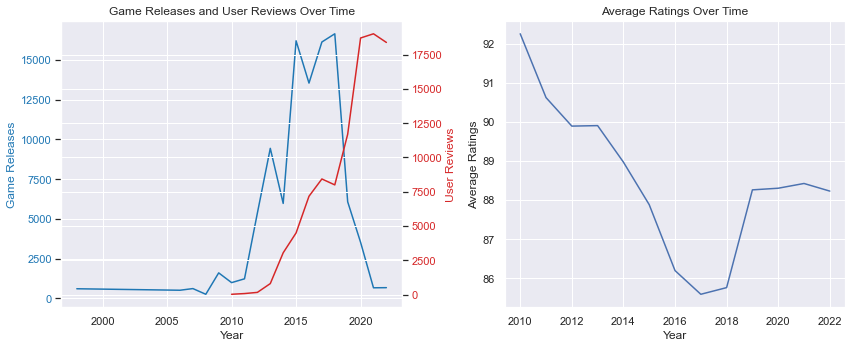

In [26]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
#user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].sum()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].size()

avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Game Releases and User Reviews Over Time
ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_title('Game Releases and User Reviews Over Time')

# Plot Average Ratings Over Time
ax3.plot(avg_ratings_by_year.index, avg_ratings_by_year)
ax3.set_xlabel('Year')
ax3.set_ylabel('Average Ratings')
ax3.set_title('Average Ratings Over Time')

fig.tight_layout()
plt.show()

From our plot, we can observe the following trends:

- Game releases: The strong increase in the number of game releases from 2006 to 2018 could be due to various factors, such as advancements in technology, increased accessibility to game development tools, and growth in the gaming market. The decline after 2018 might be a result of market saturation, changes in the platform's policies, or a shift in focus towards quality over quantity.
- User reviews: Steam started taking user reviews in 2013. The increase in user reviews from 2013 to 2020 might be due to the growing number of active users on the Steam platform and the increase in game releases during this period. The huge drop in 2020 could be attributed to external factors, such as the COVID-19 pandemic, which may have impacted users' gaming habits, their ability to purchase new games, or their motivation to write reviews. The drop in 2020 informs us about the reviews which are in the raw data which may not be extremely "up to date" with the most recent years.
- Average ratings: The increase in average ratings from 2011 to 2014 and the subsequent decrease from 2014 to 2017 suggest a possible change in user preferences, game quality, or the types of games being released during these periods. The increase in average ratings from 2017 to 2022 could indicate that developers are adapting to user preferences, creating higher quality games, or that the platform is promoting more critically acclaimed titles.

### **Comparison of mean playtime and median playtime in terms of skewness**

We compare mean and median playtime in terms of skewness to gain a better understanding of the distribution of the 'hours' column. This helps use to decide whether to use the mean or median for further analysis.

Number of outliers in 'hours' column: 8130
Skewness of 'hours' column: 1.6005194187164307
The 'hours' column is highly skewed. It is recommended to use the median for further analysis.


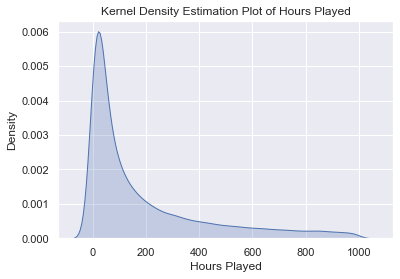

In [27]:
# skewness of the 'hours' column


# Step 1: Assess the distribution of the 'hours' column
skewness = final_df['hours'].skew()

# Step 2: Use a for loop to identify outliers (using the IQR method)
Q1 = final_df['hours'].quantile(0.25)
Q3 = final_df['hours'].quantile(0.75)
IQR = Q3 - Q1

outliers = []
for hours in final_df['hours']:
    if (hours < (Q1 - 1.5 * IQR)) or (hours > (Q3 + 1.5 * IQR)):
        outliers.append(hours)

# Print the number of outliers and skewness value
print(f"Number of outliers in 'hours' column: {len(outliers)}")
print(f"Skewness of 'hours' column: {skewness}")

# Step 3: Decide whether to use the median or the mean for further analysis
if skewness > 1 or skewness < -1:
    print("The 'hours' column is highly skewed. It is recommended to use the median for further analysis.")
else:
    print("The 'hours' column is not highly skewed. It is recommended to use the mean for further analysis.")


# Create a kernel density estimation plot for the 'hours' column
sns.kdeplot(final_df['hours'], shade=True)

# Add labels and title
plt.xlabel('Hours Played')
plt.ylabel('Density')
plt.title('Kernel Density Estimation Plot of Hours Played')

# Show the plot
plt.show()

There are 28 data points in the 'hours' column that are considered outliers, based on the Interquartile Range (IQR) method. These data points lie outside the typical range of values, and they might have a significant impact on the mean and standard deviation.

The 'hours' column is highly skewed. The skewness of the 'hours' column is either greater than 1, indicating that the distribution is not symmetric and has a significant tail on one side. In this case, the tail is likely on the right side, meaning that there are a few games with extremely high playtimes compared to the majority. 

Given these results, it is recommended to use the median instead of the mean for further analysis of the 'hours' column. The median is less sensitive to outliers and provides a more accurate representation of the central tendency of the data. By using the median, you can mitigate the impact of extreme values and better understand the typical playtime for games in the dataset.

## Correlation

Since the variable 'y' is binary, and the dataset is composed of categorical, binary and continuous variable, we calculated the correlations with different coefficients.

### Continuous Variables
To calculate the correlation between "y" and continous variables, we use the point-biserial correlation coefficient. The point-biserial correlation coefficient measures the strength and direction of the association between a binary variable and a continuous variable.

The point-biserial correlation coefficient assumes that the binary variable is dichotomous, meaning it has only two possible values (in our case, 0 or 1), and that the continuous variable is normally distributed.

The point-biserial correlation is based on three assumptions: 
1. No outliers (continuous variable) - assessed through a visual examination of the scatterplot
2. Approximately normally distributed continuous variable
3. Homogeneity of variance of the continuous variable between both groups of the dichotomous variable

In [28]:
# Define the numeric variables
num_variables = ['price_final', 'positive_ratio', 'hours', 'median_playtime', 'user_reviews',
                'price_original', 'discount', 'products', 'reviews']

Check that the variables meet the requirements for the point-biserial correlation.

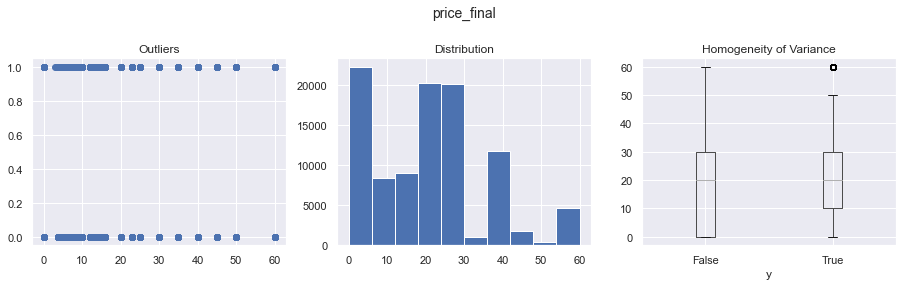

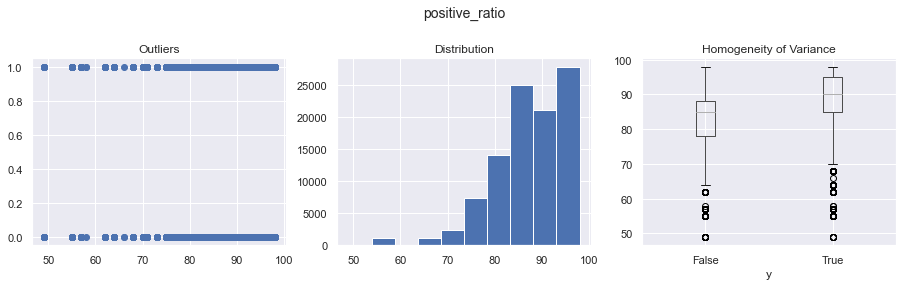

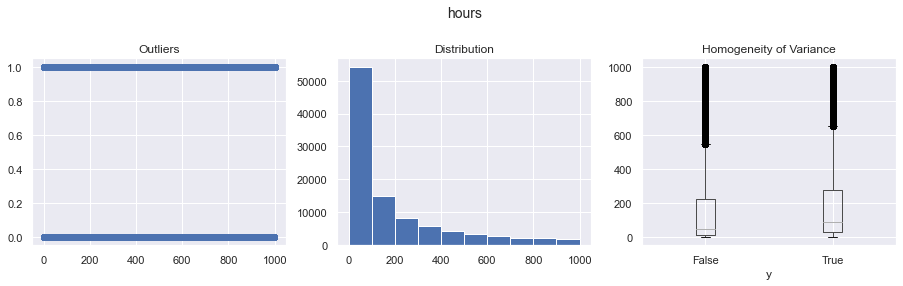

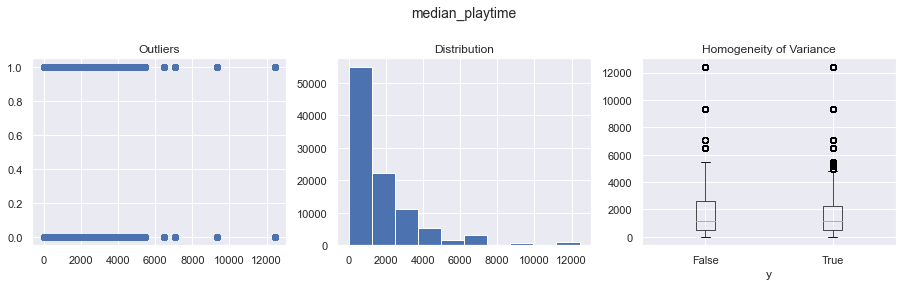

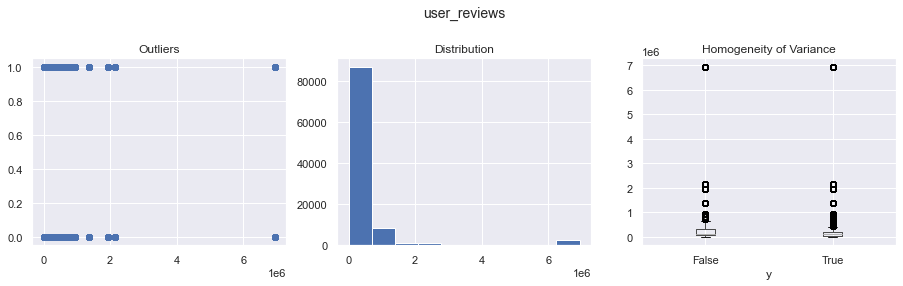

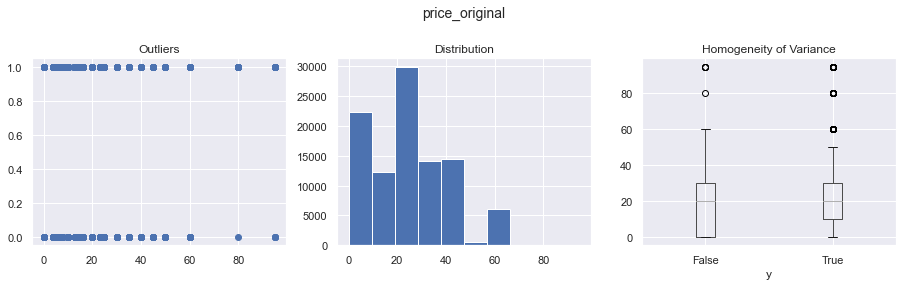

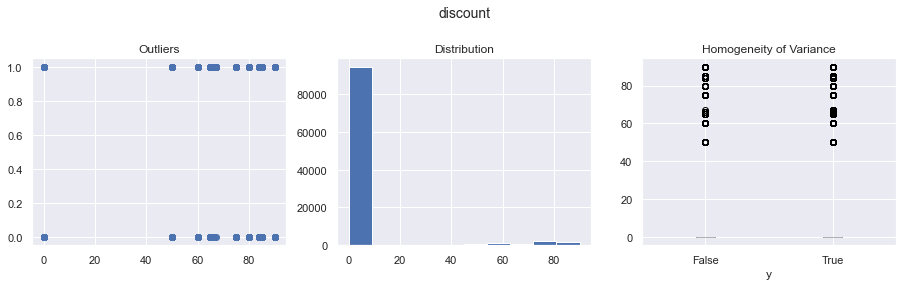

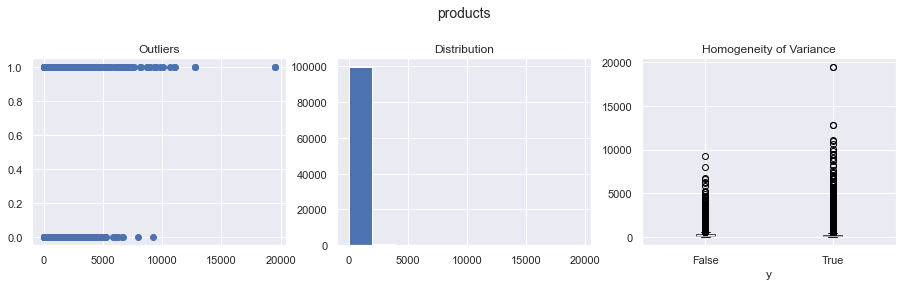

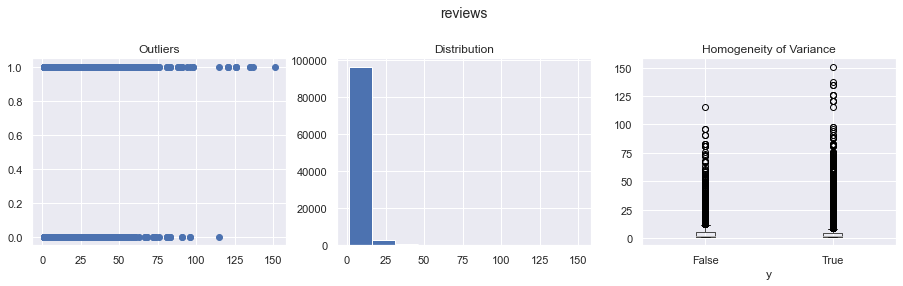

In [29]:
# loop through the numeric variables
def check_req(df, variable_list):
    for var in variable_list:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        # Check for outliers with a scatterplot
        axs[0].scatter(df[var], final_df['y'])
        axs[0].set_title("Outliers")

        # Check for normal distribution with a histogram
        axs[1].hist(df[var])
        axs[1].set_title("Distribution")

        # Check for homogeneity of variance with a boxplot
        df.boxplot(column=var, by='y', ax=axs[2])
        axs[2].set_title("Homogeneity of Variance")

        # Set overall title
        plt.suptitle(var, fontsize=14)
        fig.subplots_adjust(top=0.8)

        plt.show()
        
check_req(final_df, num_variables)

In [30]:
# Create a new DataFrame to store the normalized variables
final_df_log = pd.DataFrame()

var_to_norm = ['hours', 'median_playtime', 'user_reviews',
                'products', 'reviews']

# Loop over the variables and apply log transformation to each one
for col in var_to_norm:
    final_df_log[col] = np.log(final_df[col] + 0.0001)
    
final_df_norm = pd.concat([final_df.drop(var_to_norm, axis=1), final_df_log], axis=1)

In [31]:
# Calculate correlation based on the normalized dataset 
cor_matrix = []

for variable in num_variables:
    r_pb, p_value = pointbiserialr(final_df_norm['y'], final_df_norm[variable])
    cor_matrix.append({'Variable name': variable, 'corr': r_pb, 'p-value': p_value})

cor_df = pd.DataFrame(cor_matrix)
cor_df['corr'] = abs(cor_df['corr'])
display(cor_df.sort_values(by="corr", ascending = False))

,Variable name,corr,p-value
1,positive_ratio,0.264822,0.000000e+00
2,hours,0.172609,0.000000e+00
7,products,0.085274,9.876050e-161
8,reviews,0.061251,9.908749e-84
4,user_reviews,0.034498,1.005455e-27
0,price_final,0.033896,8.039414e-27
5,price_original,0.025275,1.307406e-15
3,median_playtime,0.003413,2.804626e-01
6,discount,0.003025,3.387933e-01


Making the correlation coefficient absolute, we can state the the variables more with a stronger correlation to y are positive_ratio and hours. The ones that follow in the dataset are still correlated (all the p-values are <0.5), but with coefficients lower than 10%.

In any case, we notice that the correlations are not strong across all the variables, with values that don't go over 25%.

### Binary variables
Phi is a measure for the strength of an association between two categorical variables in a 2 × 2 contingency table. It is calculated by taking the chi-square value, dividing it by the sample size, and then taking the square root of this value. It varies between 0 and 1 without any negative values.

In [32]:
# Define binary variables
bin_variables = ['mac', 'linux']

In [33]:
# Check that they all have two different values
for var in bin_variables: 
    print(var, final_df[var].unique())

mac [False  True]
linux [False  True]


In [34]:
# Calculate their phi value and its p-value
warnings.filterwarnings("ignore", category=FutureWarning)

phi_df = pd.DataFrame(columns=['Variable name', 'corr', 'p-value'])

for var in bin_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    ChiSqResult = chi2_contingency(contingency)
    n = contingency.values.sum()
    phi = np.sqrt(ChiSqResult[0] / n)
    p_value = ChiSqResult[1]
    
    phi_df = phi_df.append({'Variable name': var, 'corr': phi, 'p-value': p_value}, ignore_index=True)

display(phi_df)

,Variable name,corr,p-value
0,mac,0.083813,0.0
1,linux,0.090717,0.0


### Categorical variables
Cramer's V is an alternative to phi in tables bigger than 2 × 2 tabulation. Cramer's V varies between 0 and 1 without any negative values. Similar to Pearson's r, a value close to 0 means no association. However, a value bigger than 0.25 is named as a very strong relationship for the Cramer's V.

In [35]:
# Define categorical variables
cat_variables = ['rating', 'developer', 'publisher', 'achievements']

In [36]:
# Check that they all have more than two different values
for var in cat_variables: 
    print(var, final_df[var].nunique())

rating 4
developer 251
publisher 197
achievements 113


In [37]:
# calculate Cramer V coefficient for each variable and y
results = []
for var in cat_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    chi2 = chi2_contingency(contingency)[0]
    N = len(final_df)
    minimum_dimension = (min(contingency.shape)-1)
    result = np.sqrt((chi2/N) / minimum_dimension)
    p_value = chi2_contingency(contingency)[1]
    results.append({'Variable name': var, 'corr': result, 'p-value': p_value})

# create dataframe with results
results_df = pd.DataFrame(results).sort_values(by='corr', ascending=False)

display(results_df)

,Variable name,corr,p-value
1,developer,0.286049,0.0
2,publisher,0.275078,0.0
0,rating,0.235758,0.0
3,achievements,0.209119,0.0


## Custom Pipeline Class Construction

### Feature Engineering

#### Elapsed Time CHECK
Here we construct the custom pipeline class ElapsedTimeTransformer, which creates a new feature called _elapsed_time_. This is the amount of time which has passed since a product's release date and the user reviewing it. This could be a proxy for how "into a product" a given user could be. The class takes the following arguments:
- **add_elapsed**: Receives a boolean to determine whether to create the new column. Deafult is True
- **drop_features**: Receives a boolean to determine whether to drop _date_ and _date_release_ columns after having created _add_elapsed_. These variables are not particularly useful for the regression so it may be worthwhile to remove them from the DataFrame. Default is True.

In [38]:
class ElapsedTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_elapsed=True, drop_features=True):
        self.add_elapsed = add_elapsed
        self.drop_features = drop_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.add_elapsed:
            X = X.copy()
            elapsed_time = (pd.to_datetime(X["date"]) - pd.to_datetime(X["date_release"])).dt.days
            X = X.assign(elapsed_time=elapsed_time)

        if self.drop_features:
            X = X.drop(['date', 'date_release'], axis=1)

        return X

#### Tendency to Review
Here we construct the custom pipeline class TendencyToReview. Its purpose is to create a new feature _tendency_to_review_ which is the ratio between reviews by a user and number of products. It allows us to gauge how often a user leaves reviews. People tend to rarely leave reviews, as shown in the exploratory data analysis above. Consequently, the class standardises the resulting data. The arguments are the following:
- **drop_columns**: Receives a boolean to determine whether to drop _products_ column. Deafult is True.
- **standardize**: Receives a boolean to determine whether to standarsize the resulting data or not. Default is True.

In [39]:
class TendencyToReview(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_words=True, standardize=True):
        
        self.drop_words = drop_words
        self.standardize = standardize

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["tendency_to_review"] = (X["reviews"]) / (X["products"])
        X["tendency_to_review"] = np.where(X["tendency_to_review"] == np.inf, 2, X["tendency_to_review"])
        if self.drop_words:
            X = X.drop("products", axis=1)
        if self.standardize:
            scaler = MinMaxScaler()
            X["tendency_to_review"] = scaler.fit_transform(X[["tendency_to_review"]])
        return X

#### Ordinally Encoded Steam Rating
Here we construct the custom pipeline class SteamRatingEncoder. Its purpose is to transform the Steam categorical ratings in the _rating_ column (whose meanings are better explained in a_csv_creation.ipynb) into an ordinally encoded feature. However, given that the categories follow a diverging pattern (where "Mixed" is a middle ground and games can have varying degrees of Positive or Negative feedback), we encode them as such. We give users the possibility of encoding them with a standard scale that goes from -4 to 4, or a slightly more weighted one which attempts to numerically translate the large difference between being simply "Mostly Positive" (or Negative) and being "Positive" (or Negative). The class has the following arguments:

- **drop_rating**: Receives a boolean to determine whether to drop the _rating_ categorical column. Deafult is True.
- **standard_diverging_scale**: Receives a boolean to determine whether to use the standard scale instead of the weighted one. Default is True.

In [40]:
class SteamRatingEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_rating=True, standard_diverging_scale=True):
        
        self.drop_rating = drop_rating
        self.standard_diverging_scale = standard_diverging_scale
        
        if standard_diverging_scale:
            self.rating_dict = {
                "Overwhelmingly Positive": 4,
                "Very Positive": 3,
                "Positive": 2,
                "Mostly Positive": 1,
                "Mixed": 0,
                "Mostly Negative": -1,
                "Negative": -2,
                "Very Negative": -3,
                "Overwhelmingly Negative": -4
            }
        else:
            self.rating_dict = {
                "Overwhelmingly Positive": 9,
                "Very Positive": 8,
                "Positive": 7,
                "Mostly Positive": 4,
                "Mixed": 0,
                "Mostly Negative": -4,
                "Negative": -7,
                "Very Negative": -8,
                "Overwhelmingly Negative": -9
            }
            
        self.drop_rating = drop_rating

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['rating_encoded'] = X['rating'].map(self.rating_dict)
        if self.drop_rating:
            X = X.drop(['rating'], axis=1)
        return X

#### Developer and Distributor Metrics
Here we construct the custom pipeline class DevDisTransformer. Depending on the arguments which are passed to it, it can create up to three new features. It utilizes target encoding on both the developer and distributor columns and has gives the users the possibility to also create an interaction feature between these two variables. The idea is that there may be developers which tend to put out better games than others, or distributors which tend to pick up better games than others. Sometimes, it is the collaboration between a particular developer and distributor which creates true "videogaming gold". Consequently, we give the possibility of creating an interaction term. The class' arguments are the following:
- **y**: Receives the y values corresponding to the dataset being transformed. Needed for Target Encoding.
- **encode_dev**: Receives a boolean to determine whether to target encode the _developer_ column. Deafult is True.
- **encode_dis**: Receives a boolean to determine whether to target encode the _distributor_ column. Deafult is True.
- **drop_cols**: Receives a boolean to determine whether to drop the _developer_ and _distributor_ columns after the transformation. Default is True.
- **interaction**: Receives a boolean to determine whether to create interaction term or not. Default is True.

In [41]:
class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y, encode_dev=True, encode_dis=True, drop_cols=True, interaction=True):
        self.encode_dev = encode_dev
        self.encode_dis = encode_dis
        self.drop_cols = drop_cols
        self.interaction = interaction
        self.y = y
        self.encoder_dev = TargetEncoder()
        self.encoder_dis = TargetEncoder()

    def fit(self, X, y=None):
        if self.encode_dev:
            self.encoder_dev.fit(X["developer"], self.y)
        if self.encode_dis:
            self.encoder_dis.fit(X["distributor"], self.y)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if self.encode_dev:
            X["targ_encode_dev"] = self.encoder_dev.transform(X["developer"])
        if self.encode_dis:
            X["targ_encode_dis"] = self.encoder_dis.transform(X["distributor"])
        if self.interaction:
            X["dev_dis_interaction"] = X["targ_encode_dev"] * X["targ_encode_dis"]
        if self.drop_cols:
            X.drop(columns=["developer", "distributor"], inplace=True)
        return X


#### Genre Dummy Interactions
Here we construct the custom pipeline class InteractionsTransformer. When called, it finds the maximum number of genre dummies which are positive across all rows. Based on what it finds, it calls a PolynomialFeatures with the approriate degree to capture every single interaction without making the features overly complex (e.g. by setting a higher degree than necessary to capture all interactions). The PolynomialFeatures only returns the interaction terms (no quadratic terms) and adds them to the DataFrame. This can be used for both the genre dummies and the OS dummies. The argument is only one:

- **columns**: Receives the columns with dummies. If not specified, the list of genres in our dataset is used.

In [42]:
class InteractionsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        if columns is None:
            columns = ['Action', 'Adventure', 'Animation & Modeling', 'Casual',
                       'Design & Illustration', 'Early Access', 'Free to Play', 'Gore',
                       'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing',
                       'Sexual Content', 'Simulation', 'Sports', 'Strategy',
                       'Utilities', 'Violent', 'Web Publishing']
        self.columns = columns
    
    def fit(self, X, y=None):
        # Extract the relevant columns and find the maximum number of positive dummies
        X_cols = X.loc[:, self.columns]
        max_positives = X_cols.sum(axis=1).max()
        
        # Set the degree of PolynomialFeatures to the maximum number of positive dummies
        self.poly = PolynomialFeatures(interaction_only=True, degree=max_positives)
        
        # Fit the PolynomialFeatures transformer
        self.poly.fit(X_cols)
        
        return self
    
    def transform(self, X):
        # Apply the PolynomialFeatures transformer to the relevant columns
        X_cols = X.loc[:, self.columns]
        X_poly_cols = self.poly.transform(X_cols)
        
        # Concatenate the transformed features with the original input data
        X_poly = np.concatenate([X.drop(columns=self.columns).values, X_poly_cols], axis=1)
        
        return X_poly

#### Owners Transformer
Here we construct the custom pipeline class OwnersTransformer. When called, it ordinally encodes the owners column, which contains the range of owners for a given game in string format. We do not run standard ordinal encoding due to some categories having far too few datapoints. Instead, we encode according to order of magnitude of users (e.g. 0-100 users is one category, 100-1000 another, and so on). We give the possibility of creating another feature which interacts the ordinally encoded user count with the Massively Multiplayer dummy. The idea is that games which rely on user interaction as a key mechanic may be more likely to receive better ratings. The class receives the following argumnets:

- **inter_term**: Receives a boolean to determine whether to create the interaction term. True by default.
- **owner_drop**: Receives a boolean to determine whether to drop the owners column after creating the new features. True by default.

In [43]:
class OwnersTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, inter_term=True, owner_drop=True):
        self.inter_term = inter_term
        self.owner_drop = owner_drop
        self.ordinal_encode_dict = {
            '0-20': 0,
            '20-50': 0,
            '50-100': 0,
            '100-200': 1,
            '200-500': 1,
            '500-1000': 1,
            '1000-2000': 2,
            '2000-5000': 2,
            '5000-10000': 2,
            '10000-20000': 3,
            '20000-50000': 3,
            '50000-100000': 3,
            '100000-200000': 4
        }
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ordinal encoding of owners column
        X["encoded_owners"] = X["owners"].map(self.ordinal_encode_dict)

        # Interaction term between encoded_owners and Massive Multiplayer column
        if self.inter_term:
            X["owner_multiplayer_int"] = X["encoded_owners"] * X["Massively Multiplayer"]

        # Drop owners column
        if self.owner_drop:
            X = X.drop("owners", axis=1)

        return X

### Feature Transformers

#### Grouped Scaler

Here we construct a custom class pipeline called GroupedStandardScaler built to run a StandardScaler on a given column (or columns) grouping data according to a provided column. The class takes the following arguments:

- **groupby_column**: Takes a string corresponding to the column by which the data should be grouped. Default is "app_id".
- **columns_to_normalize**: Takes the column whose data is to be normalized. Default is None.

In [44]:
class GroupedStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, groupby_column='app_id', columns_to_normalize=None):
        self.groupby_column = groupby_column
        self.columns_to_normalize = columns_to_normalize
        self.scalers = {}

    def fit(self, X, y=None):
        # Create a scaler for each group in the groupby column
        groups = X.groupby(self.groupby_column)
        for group_name, group in groups:
            scaler = StandardScaler()
            if self.columns_to_normalize is None:
                columns_to_normalize = group.columns
            else:
                columns_to_normalize = self.columns_to_normalize
            scaler.fit(group[columns_to_normalize])
            self.scalers[group_name] = scaler
        return self

    def transform(self, X, y=None):
        # Apply normalization to each group in the groupby column
        groups = X.groupby(self.groupby_column)
        X_transformed = []
        
        for group_name, group in groups:
            if group_name in self.scalers:
                scaler = self.scalers[group_name]
                group_transformed = group.copy()
                if self.columns_to_normalize is None:
                    columns_to_normalize = group.columns
                else:
                    columns_to_normalize = self.columns_to_normalize
                group_transformed[columns_to_normalize] = scaler.transform(group[columns_to_normalize])
                X_transformed.append(group_transformed)
        if len(X_transformed) > 0:
            X_transformed = pd.concat(X_transformed)
        else:
            X_transformed = X.copy()
        return X_transformed

#### Dropping Columns
Here we construct the custom pipeline class DropColumns. It receives a list of strings and drops from the DataFrame any column whose name is in the list. This class only receives one argument:

- **drop_columns**: Receives a list of strings telling the function which columns to drop. Default is None.

In [45]:
class DropColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.drop_columns:
            X = X.drop(columns=self.drop_columns)
        return X


## Additional Data Exploration after Feature Engeneering

To analyze the engineered features _elapsed_time_ and _tendency_to_review_, we create a new dataset where we apply the respective pipelines defined above.

In [46]:
# Apply the pipeline to generate the "elapsed_time" and the "tendency_to_review" variables
analysis_pipeline = Pipeline([
    ('tendency_to_review', TendencyToReview(drop_words=True, standardize=False)),
    ('elapsed_time', ElapsedTimeTransformer(add_elapsed=True, drop_features=False))
])

analysis_df = analysis_pipeline.fit_transform(final_df)

### Exploration of elapsed time

By analyzing the elapsed time, we can gain a better understanding about when users are most likely to write reviews, whether they tend to review games soon after release or after a significant amount of time has passed.

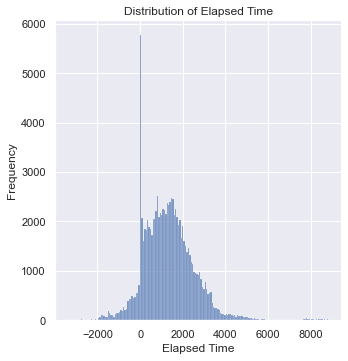

In [47]:
# Plotting the distribution of elapsed_time
sns.displot(analysis_df['elapsed_time'])

plt.title('Distribution of Elapsed Time')
plt.xlabel('Elapsed Time')
plt.ylabel('Frequency')

plt.show()

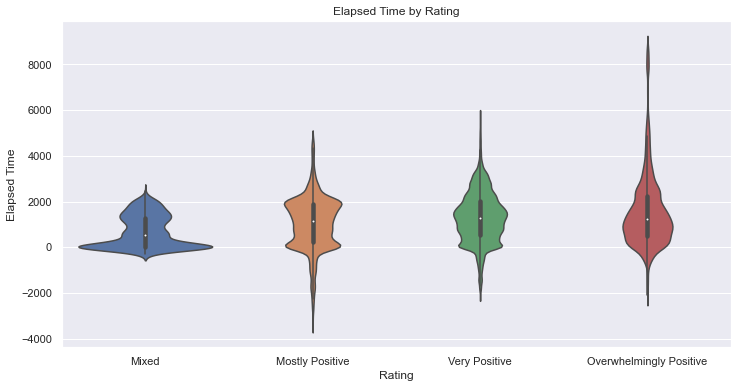

In [48]:
# Create a violin plot of review_tendency for each category of rating
plt.figure(figsize=(12,6))
ordered_categories = ['Mixed', 'Mostly Positive', 'Very Positive', 'Overwhelmingly Positive'] 
sns.violinplot(x="rating", y="elapsed_time", data=analysis_df, order=ordered_categories)

# Set the title and axis labels
plt.title("Elapsed Time by Rating")
plt.xlabel("Rating")
plt.ylabel("Elapsed Time")

# Show the plot
plt.show()

In [49]:
analysis_df['elapsed_time'].describe()

count    100000.000000
mean       1326.708310
std        1240.146153
min       -3372.000000
25%         468.750000
50%        1243.000000
75%        2001.000000
max        8819.000000
Name: elapsed_time, dtype: float64

### Exploration of review tendency

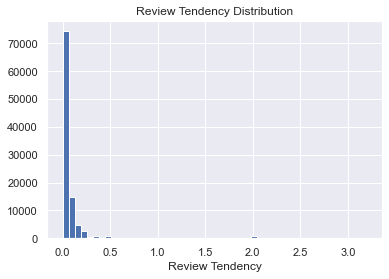

In [50]:
# Create a histogram of review_tendency variable in the first subplot
plt.hist(analysis_df["tendency_to_review"], bins=50)
plt.title("Review Tendency Distribution")
plt.xlabel("Review Tendency")
plt.show()

The distribution of the variable review_tendency suggests that users tend to review a relatively small number of games. The mean value of 0.054 and the median value of 0.027 indicate that on average, users leave a review for only a small fraction of the games they own. Moreover, we need to take into account that every user recorded in the dataset has left at least one review. This suggests that the value of tendency to review calculated on the whole population would be considerely lower.

We can assume, as a consequence, that users only review games when they have a strong opinion about it. We check, then, if and how the tendency to review influences the review score.

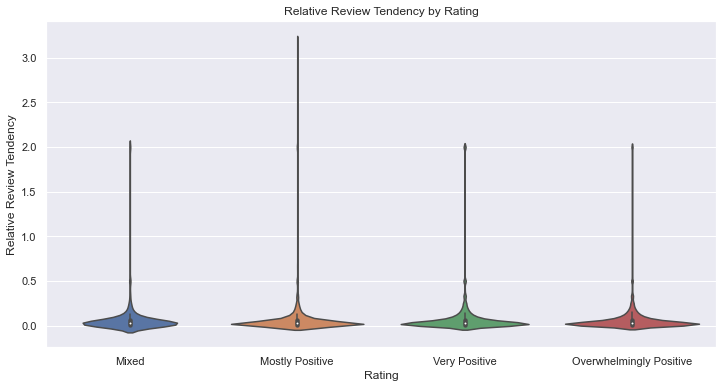

In [51]:
# Create a violin plot of review_tendency for each category of rating
plt.figure(figsize=(12,6))
ordered_categories = ['Mixed', 'Mostly Positive', 'Very Positive', 'Overwhelmingly Positive'] 
sns.violinplot(x="rating", y="tendency_to_review", data=analysis_df, order=ordered_categories)

# Set the title and axis labels
plt.title("Relative Review Tendency by Rating")
plt.xlabel("Rating")
plt.ylabel("Relative Review Tendency")

# Show the plot
plt.show()

Comparing users' relative tendency to review to the rating they gave to the games, we notice how the higher is the tendency to review, the higher the scores given.

One possible explanation for this phenomenon is that users who are more active in reviewing games may have a stronger interest and engagement with the gaming community, and are therefore more likely to enjoy the games they play and give them higher ratings.

Alternatively, it could be that users who have a more positive overall attitude towards games are more likely to review them and give them higher ratings, while users who are more critical or have a negative bias may not review games as often or may be more likely to give lower ratings.

## Model Construction

In the following part, a Logistic Regression model is being used to predict whether a user would like a game or not, which is represented by the binary target variable 'y'. The dataset is first split into features (X) and target (y) and then further split into training and validation sets.

Two versions of the logistic model are created and compared:

The first logistic model uses a limited set of features: 'price_final', 'positive_ratio', 'hours', 'median_playtime'. A preprocessor is created using ColumnTransformer and StandardScaler to standardize these numerical features. A pipeline is created with the preprocessor and a LogisticRegression model with L2 regularization. GridSearchCV is used to optimize the penalty hyperparameter ('C') and regularization type ('penalty') over a range of values, using 10-fold cross-validation and F1 score as the evaluation metric.
The second logistic model adds more features to the first model: 'reviews', 'products', 'discount', 'funny', 'helpful', 'user_reviews', 'price_original', 'required_age', 'achievements'. A new preprocessor is created to standardize these additional numerical features. The same pipeline, grid search, and cross-validation process from the first model is used to optimize the hyperparameters and evaluate the model.
The performance of the second model is compared to the first model to see if adding more features improved the F1 score.

In the third part, Synthetic Minority Over-sampling Technique (SMOTE) is added to the pipeline to address potential class imbalance in the target variable 'y'. A new parameter grid is created to optimize SMOTE's sampling strategy, the number of nearest neighbors, and the logistic regression penalty hyperparameter. Grid search and cross-validation are performed on this pipeline, and the model's performance is compared to the second logistic model to see if adding SMOTE improved the F1 score.
In summary, a logistic regression model is used in this code to predict whether a user would like a game or not based on various features. The model is optimized and compared across different sets of features and with the addition of SMOTE to address class imbalance.

**Train-Test Split** AAAAAAAA

### Model 1: Content Similarity Score

While this is model...

In [52]:
textual_df.head()

,title,description,tags,genres,steamspy_tags,categories,full_text
app_id,,,,,,,
304390,FOR HONOR™,"carve path destruction intense, believable bat...",medieval swordplay action multiplayer pvp figh...,action,medieval action swordplay,single-player online multiplayer online coop s...,single-player online multiplayer online coop s...
306130,The Elder Scrolls® Online,join 20 players award-winning online multiplay...,rpg mmorpg open world adventure fantasy explor...,massive-multiplayer rpg,rpg open world mmorpg,mmo steam trading cards partial controller sup...,mmo steam trading cards partial controller sup...
238960,Path of Exile,"exile, struggling survive dark continent wraec...",free-to-play action rpg hack and slash rpg mul...,action adventure free-to-play indie massive-mu...,free-to-play action rpg hack and slash,single-player multiplayer online multiplayer m...,single-player multiplayer online multiplayer m...
730,Counter-Strike: Global Offensive,counter-strike: global offensive (cs: go) expa...,fps shooter multiplayer competitive action tea...,action free-to-play,fps multiplayer shooter,multiplayer steam achievements full controller...,multiplayer steam achievements full controller...
255710,Cities: Skylines,cities: skylines modern classic city simulatio...,city builder simulation building management st...,simulation strategy,city builder simulation building,single-player steam achievements steam trading...,single-player steam achievements steam trading...


In [53]:
# Define the custom class
class SimilarityGenerator:
    
    def __init__(self, similarity):
        self.similarity = similarity
        
        # Define multi_review dataframe within the class
        duplicated_user_ids = user_df[user_df.duplicated(subset=["user_id"], keep=False)]["user_id"].unique()
        self.multi_review = user_df[user_df["user_id"].isin(duplicated_user_ids)].reset_index(drop=True)
        
    def transform(self, X):
        similarities = []
        for i in range(len(X)):
            user = X[i][0]
            game = X[i][1]
            sim = self.AverageSimilarityCalculator(user, game)
            similarities.append(sim)
        return np.array(similarities).reshape(-1, 1)
    
    def AverageSimilarityCalculator(self, user, game):
        user_ratings = self.multi_review[self.multi_review["user_id"] == user]
        other_games = user_ratings[user_ratings['app_id'] != game]
        other_games_titles = other_games['app_id']
        filtered_game_similarity_df = self.similarity.loc[game, other_games_titles] * other_games.set_index('app_id')["y"]
        return filtered_game_similarity_df.mean()


In [54]:
# Create the pipeline
SVD_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', strip_accents='ascii', use_idf=False)),
    ('svd', TruncatedSVD(n_components=160, random_state=70))
])

# Fit the pipeline on the full text data
SVD_pipeline.fit(textual_df['full_text'])

# Compute the similarity matrix on the full text data
reduced_features = SVD_pipeline.transform(textual_df['full_text'])
similarity_matrix = 1 - pairwise_distances(reduced_features, metric='cosine')

### Model 2: Logistic Regression

### Model 3: Decision Tree

## Model Evaluation